In [8]:
# importing standard packages
import pandas as pd
import numpy as np 
from scipy import stats 

# importing the plot funnctions
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# preprocessing/ model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# importing the classifiers 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# importing the metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.metrics import roc_curve

# oversampling techniques 
from imblearn.over_sampling import SMOTE

# importing model saving package 
from joblib import dump, load

from sklearn.model_selection import learning_curve,GridSearchCV


In [17]:
# grab the stored data frames
%store -r X_train_U
%store -r y_train_U
%store -r X_test
%store -r y_test

In [18]:
X_train_U.shape, y_train_U.shape, X_test.shape, y_test.shape

((12664, 598), (12664, 1), (18343, 598), (18343, 1))

In [2]:
rf_u = load("RF_U.joblib")

In [3]:
print(rf_u.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [11]:
rf_untrained = RandomForestClassifier()
rf_params = {'n_estimators': [200, 500], 'max_depth': [3,7,15,50]}
rf_grid_search = GridSearchCV(rf_untrained, rf_params, cv = 4, scoring = 'recall', n_jobs = -1)
rf_grid_search.fit(X_train_U.values, y_train_U.values)
rf_grid_search.best_params_

C:\Users\vamik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 50, 'n_estimators': 500}

In [12]:
rf_untrained = RandomForestClassifier()
rf_params = {'n_estimators': [200, 500], 'max_depth': [3,7,15,50]}
rf_grid_search = GridSearchCV(rf_untrained, rf_params, cv = 4, scoring = 'f1', n_jobs = -1)
rf_grid_search.fit(X_train_U.values, y_train_U.values)
rf_grid_search.best_params_

C:\Users\vamik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 50, 'n_estimators': 200}

In [13]:
rf_untrained = RandomForestClassifier()
rf_params = {'n_estimators': [200, 500], 'max_depth': [3,7,15,50]}
rf_grid_search = GridSearchCV(rf_untrained, rf_params, cv = 4, scoring = 'precision', n_jobs = -1)
rf_grid_search.fit(X_train_U.values, y_train_U.values)
rf_grid_search.best_params_

C:\Users\vamik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 3, 'n_estimators': 500}

In [21]:
def draw_conf_mat(mat):
    
    """
    Draw confusion matrix
    
    Parameters:
    ------------------
    mat:                ndarray of shape (n_classes, n_classes) 
                        confusion matrix

    """
    
    import matplotlib.pyplot as plt 
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    return ax

### Running the model with the new parameters

In [35]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'RF_U': RandomForestClassifier(n_estimators= 500, max_depth = 3)}

In [36]:
# keys for the classifiers 
selected_clfs = ['RF_U']

In [37]:
clf_under_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train_U, y_train_U.values.ravel())
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train_U)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test.values.ravel(), y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test.values.ravel(), y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test.values.ravel(), y_proba)

    #f1 score on test
    f1_test = f1_score(y_test.values.ravel(), y_predict)

    #f1 score on train
    f1_train = f1_score(y_train_U.values.ravel(), y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train_U, y_train_U.values.ravel(), cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], 
                       columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_under_matrix = pd.concat([df2, clf_under_matrix])


-------- classifier being run is RF_U ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


RF_U


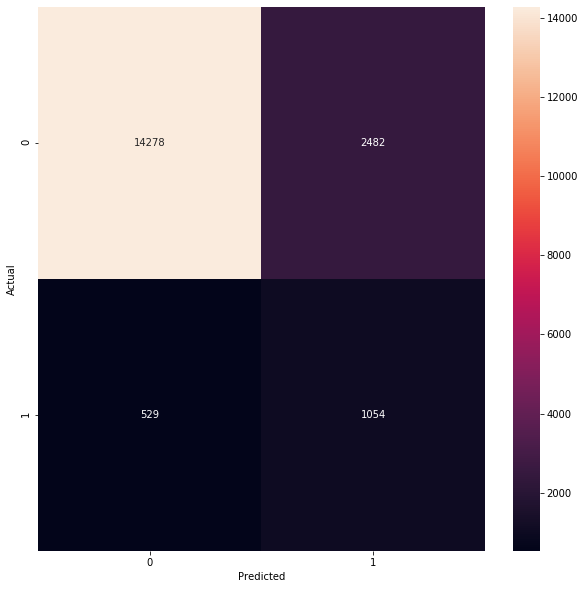

In [38]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)

In [39]:
clf_under_matrix

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,RF_U,0.298077,0.665824,0.148091,0.840357,0.411799,0.733583,"[0.7137364557846906, 0.7387826086956522, 0.736..."


In [34]:
### We tried running the RF model with {n_estimators = 500, max_depth = 50} and {n_estimators = 200, max_depth = 50}, as well
### In both instances, the model suffered from severe overfitting (f1_train = 1.0). We decided to use the results above to
### compare to our LightGBM model after GridSearchCV.